In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install -q transformers sentencepiece datasets evaluate seqeval
# %pip install -q --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
import pandas as pd
import regex as re
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import pandas as pd

In [ ]:
label_list = ["B-LOCATION", "B-ORGANIZATION", "B-PERSON", "I-LOCATION", "I-ORGANIZATION","I-PERSON","O"]

# label_list = ["B-FESTIVAL","B-GAME","B-LANGUAGE","B-LITERATURE","B-LOCATION","B-MISC","B-NUMEX","B-ORGANIZATION",
#               "B-PERSON","B-RELIGION","B-TIMEX","I-FESTIVAL","I-GAME","I-LANGUAGE","I-LITERATURE","I-LOCATION",
#               "I-MISC","I-NUMEX","I-ORGANIZATION","I-PERSON","I-RELIGION","I-TIMEX","O"]

hiner = load_dataset('cfilt/HiNER-collapsed')
# hiner = load_dataset('cfilt/HiNER-original')

# train_tokens = hiner["train"]["tokens"]
# train_tags = hiner["train"]["ner_tags"]
# val_tokens = hiner["validation"]["tokens"]
# val_tags = hiner["validation"]["ner_tags"]
# test_tokens = hiner["test"]["tokens"]
# test_tags = hiner["test"]["ner_tags"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
# @title Metrics

# import tensorflow as tf

# class F1Score(tf.keras.metrics.Metric):
#     def __init__(self, name='f1_score', **kwargs):
#         super(F1Score, self).__init__(name=name, **kwargs)
#         self.num_classes = len(label_list)

#         self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

#         self.accuracy = self.add_weight(name='accuracy', initializer='zeros')
#         self.f1 = self.add_weight(name='f1', initializer='zeros')
#         self.precision = self.add_weight(name='precision', initializer='zeros')
#         self.recall = self.add_weight(name='recall', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_pred = tf.argmax(y_pred, axis=-1)
#         y_pred = tf.one_hot(y_pred, self.num_classes)
#         y_true = tf.one_hot(y_true, self.num_classes)
#         y_true = tf.cast(y_true, dtype=tf.bool)
#         y_pred = tf.cast(y_pred, dtype=tf.bool)

#         true_positives = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true, y_pred), dtype=tf.float32), axis=[0,1])
#         true_negatives = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_true), tf.math.logical_not(y_pred)), dtype=tf.float32), axis=[0,1])
#         false_positives = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_true), y_pred), dtype=tf.float32), axis=[0,1])
#         false_negatives = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true, tf.math.logical_not(y_pred)), dtype=tf.float32), axis=[0,1])
#         # print(true_positives.shape)

#         accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-7)
#         precision = true_positives / (true_positives + false_positives + 1e-7)
#         recall = true_positives / (true_positives + false_negatives + 1e-7)
#         f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

#         accuracy = tf.reduce_sum(accuracy)
#         f1 = tf.reduce_sum(f1)
#         precision = tf.reduce_sum(precision)
#         recall = tf.reduce_sum(recall)

#         self.accuracy.assign_add(accuracy)
#         self.f1.assign_add(f1)
#         self.precision.assign_add(precision)
#         self.recall.assign_add(recall)

#         self.total_samples.assign_add(tf.cast(tf.shape(y_true)[0], dtype=tf.float32))

#     def result(self):
#         return {"MyAccuracy": self.accuracy/self.total_samples, "F1": self.f1/self.total_samples, "Precision": self.precision/self.total_samples, "Recall": self.recall/self.total_samples}

#     def reset_state(self):
#         self.accuracy.assign(tf.zeros(()))
#         self.f1.assign(tf.zeros(()))
#         self.precision.assign(tf.zeros(()))
#         self.recall.assign(tf.zeros(()))
#         self.total_samples.assign(tf.zeros(()))






# import tensorflow as tf

# class F1Score(tf.keras.metrics.Metric):
#     def __init__(self, name='f1_score', **kwargs):
#         super(F1Score, self).__init__(name=name, **kwargs)
#         self.num_classes = len(label_list)

#         self.accuracy = tf.keras.metrics.CategoricalAccuracy()
#         self.f1 = tf.keras.metrics.F1Score()
#         self.precision = tf.keras.metrics.Precision()
#         self.recall = tf.keras.metrics.Recall()

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         # y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)
#         y_true = tf.one_hot(y_true, self.num_classes)

#         # y_pred = tf.argmax(y_pred, axis=-1)
#         # t_true = tf.cast(y_true, tf.float32)
#         self.accuracy.update_state(y_true, y_pred)
#         self.f1.update_state(y_true, y_pred)
#         self.precision.update_state(y_true, y_pred)
#         self.recall.update_state(y_true, y_pred)

#     def result(self):
#         return {"MyAccuracy": self.accuracy.result(), "F1": self.f1.result(), "Precision": self.precision.result(), "Recall": self.recall.result()}

#     def reset_state(self):
#         self.accuracy.reset_state()
#         self.f1.reset_state()
#         self.precision.reset_state()
#         self.recall.reset_state()

In [ ]:
# @title Data Iterators
# def pad_sequences(x, y):
#   return [[y]*(180-len(x))+x][-180:]


# def train_series(split, tokens=True):
#     data = hiner[split]
#     for i in data:
#         if tokens:
#           yield pad_sequences(i["tokens"], "<PAD>")[0],pad_sequences(i["ner_tags"], len(label_list)-1)[0],
#         else:
#           yield pad_sequences(i["tokens"], "<PAD>")[0]

# def decode(x):
#   # print(x)
#   return [[("".join([ chr(alphabet) for alphabet in tf.strings.unicode_decode(word, 'utf-8')])) for word in ans[0]] for sentence in x]

# train_gen = tf.data.Dataset.from_generator(
#     lambda: train_series(split = "train"),
#     output_signature=(
#          tf.TensorSpec(shape=(None,), dtype=tf.string),
#          tf.TensorSpec(shape=(None,), dtype=tf.float32)),
#     ).batch(16).prefetch(3)


# val_gen = tf.data.Dataset.from_generator(
#     lambda: train_series(split = "validation"),
#     output_signature=(
#          tf.TensorSpec(shape=(None,), dtype=tf.string),
#          tf.TensorSpec(shape=(None,), dtype=tf.float32)),
#     ).batch(16).prefetch(3)


# test_gen = tf.data.Dataset.from_generator(
#     lambda: train_series(split = "test"),
#     output_signature=(
#          tf.TensorSpec(shape=(None,), dtype=tf.string),
#          tf.TensorSpec(shape=(None,), dtype=tf.float32)),
#     ).batch(16).prefetch(3)

# demo_train_gen = tf.data.Dataset.from_generator(
#     lambda: train_series(split = "train", tokens=False),
#     output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string),
#     )

# next(iter(demo_train_gen))

# vectorize_layer = tf.keras.layers.TextVectorization()
# vectorize_layer.adapt(demo_train_gen)


In [ ]:
# @title Old Tokenizer

# from tensorflow.keras.preprocessing.text import Tokenizer
# tokenizer= Tokenizer(oov_token= '<OOV>', filters = '')
# tokenizer.fit_on_texts(train_tokens)

# total_words = len(tokenizer.word_index) + 1

# print("Total Words: ", total_words)
# # saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # # loading
# # with open('tokenizer.pickle', 'rb') as handle:
# #     tokenizer = pickle.load(handle)

# train_tokens = tokenizer.texts_to_sequences(train_tokens)
# val_tokens = tokenizer.texts_to_sequences(val_tokens)
# test_tokens = tokenizer.texts_to_sequences(test_tokens)
# max_len = len(max(train_tokens, key=len))

# train_tokens = pad_sequences(maxlen=max_len, sequences=train_tokens, padding="post", value=0)
# train_tags = pad_sequences(maxlen=max_len, sequences=train_tags, padding="post", value=-100)
# # train_tags = tf.one_hot(train_tags,len(label_list) ,axis=-1)

# val_tokens = pad_sequences(maxlen=max_len, sequences=val_tokens, padding="post", value=0)
# val_tags = pad_sequences(maxlen=max_len, sequences=val_tags, padding="post", value=-100)
# # val_tags = tf.one_hot(val_tags,len(label_list) ,axis=-1)

# test_tokens = pad_sequences(maxlen=max_len, sequences=test_tokens, padding="post", value=0)
# test_tags = pad_sequences(maxlen=max_len, sequences=test_tags, padding="post", value=-100)
# # test_tags = tf.one_hot(test_tags,len(label_list) ,axis=-1)

In [ ]:
vocab = set()
LEN = 0
for i in tqdm(iter(hiner['train'])):
    vocab = vocab | set(i["tokens"])
    LEN += 1
# len(vocab)

75827it [02:01, 625.48it/s]


In [ ]:
from transformers import AutoTokenizer
# TOKENIZERNAME = "monsoon-nlp/hindi-bert"

# tokenizer = AutoTokenizer.from_pretrained(TOKENIZERNAME)
# tokenizer = AutoTokenizer.from_pretrained('drive/MyDrive/NLP/Tokenizer', use_Fast=False)
# tokenizer.model_max_length = 512
# tokenizer

# new_tokens = vocab - set(tokenizer.vocab.keys())
# tokenizer.add_tokens(list(new_tokens), special_tokens=True)


tokenizer = AutoTokenizer.from_pretrained('drive/MyDrive/NLP/Tokenizer')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokenizer.save_pretrained('drive/MyDrive/NLP/Tokenizer')

('drive/MyDrive/NLP/Tokenizer/tokenizer_config.json',
 'drive/MyDrive/NLP/Tokenizer/special_tokens_map.json',
 'drive/MyDrive/NLP/Tokenizer/vocab.txt',
 'drive/MyDrive/NLP/Tokenizer/added_tokens.json',
 'drive/MyDrive/NLP/Tokenizer/tokenizer.json')

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

hiner["train"] = hiner["train"].map(tokenize_and_align_labels, batched=True)
hiner["validation"] = hiner['validation'].map(tokenize_and_align_labels, batched=True)
hiner["test"] = hiner['test'].map(tokenize_and_align_labels, batched=True)

train_tokens = hiner["train"]["input_ids"]
train_tags = hiner["train"]["labels"]
val_tokens = hiner["validation"]["input_ids"]
val_tags = hiner["validation"]["labels"]
test_tokens = hiner["test"]["input_ids"]
test_tags = hiner["test"]["labels"]

Map:   0%|          | 0/75827 [00:00<?, ? examples/s]

Map:   0%|          | 0/10851 [00:00<?, ? examples/s]

Map:   0%|          | 0/21657 [00:00<?, ? examples/s]

In [ ]:
max_len = len(max(train_tokens, key=len))

train_tokens = pad_sequences(maxlen=max_len, sequences=train_tokens, padding="post", value=tokenizer.get_vocab()["[PAD]"])
train_tags = pad_sequences(maxlen=max_len, sequences=train_tags, padding="post", value=-100)
# train_tags = tf.one_hot(train_tags,len(label_list) ,axis=-1)

val_tokens = pad_sequences(maxlen=max_len, sequences=val_tokens, padding="post", value=tokenizer.get_vocab()["[PAD]"])
val_tags = pad_sequences(maxlen=max_len, sequences=val_tags, padding="post", value=-100)
# val_tags = tf.one_hot(val_tags,len(label_list) ,axis=-1)

test_tokens = pad_sequences(maxlen=max_len, sequences=test_tokens, padding="post", value=tokenizer.get_vocab()["[PAD]"])
test_tags = pad_sequences(maxlen=max_len, sequences=test_tags, padding="post", value=-100)
# test_tags = tf.one_hot(test_tags,len(label_list) ,axis=-1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Embedding, Masking, Flatten, Activation, concatenate
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
import evaluate
seqeval = evaluate.load("seqeval")

def metrix(predictions, labels):
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "f1": [results["overall_f1"]],
        "accuracy": [results["overall_accuracy"]],
        "precision": [results["overall_precision"]],
        "recall": [results["overall_recall"]],

    }

In [ ]:
class CustomCallback(Callback):
    def __init__(self, val_tokens, val_tags):
        super().__init__()
        self.val_tokens = val_tokens
        self.val_tags = val_tags
        self.df = pd.DataFrame()
    def on_epoch_end(self, epoch, batch, logs={}):
        predictions = model.predict(self.val_tokens)
        ans = metrix(predictions, self.val_tags)
        self.df = pd.concat([self.df, pd.DataFrame(ans)], ignore_index=True)
        print(self.df.iloc[-1:])

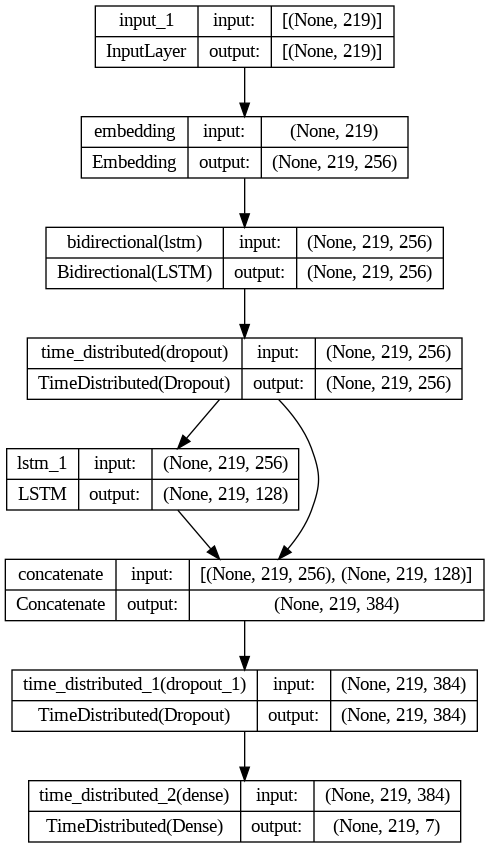

In [ ]:
input_text = Input(shape=(max_len,))
x = Embedding(len(tokenizer.get_vocab()),256, mask_zero=True)(input_text)
x = Bidirectional(LSTM(units=128, activation="tanh", return_sequences=True, dropout=0.3))(x)
x = TimeDistributed(Dropout(0.3))(x)
x_rnn = LSTM(units=128, activation="tanh", return_sequences=True,dropout=0.3)(x)
x = concatenate([x, x_rnn])
x = TimeDistributed(Dropout(0.3))(x)
x = TimeDistributed(Dense(len(label_list), activation='softmax'))(x)

model = Model(input_text, x)
model.compile(optimizer=Adam(0.003), loss=SparseCategoricalCrossentropy(ignore_class=-100), metrics = ['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)
# model.summary()

In [ ]:
metrixcallback = CustomCallback(val_tokens, val_tags)
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
checkpoint = tf.keras.callbacks.ModelCheckpoint("hiner-collapsed.h5",
                    monitor="val_loss", mode="min",
                    save_best_only=True)


# history = model.fit(train_tokens, train_tags, batch_size=64, validation_data=(val_tokens, val_tags), epochs=2, callbacks=[metrixcallback, ModelCheckpoint("lstm.h5",save_best_only=True)])
history = model.fit(train_tokens, train_tags, batch_size=64, validation_data=(val_tokens, val_tags), epochs=5, callbacks=[metrixcallback, checkpoint])

Epoch 1/5
340/340 [==============================] - 10s 17ms/step
         f1  accuracy  precision    recall
0  0.893916  0.976913   0.897491  0.890371


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1185/1185 [==============================] - 147s 106ms/step - loss: 0.1150 - accuracy: 0.0899 - val_loss: 0.0779 - val_accuracy: 0.0909
Epoch 2/5
340/340 [==============================] - 7s 19ms/step
         f1  accuracy  precision    recall
1  0.894667  0.976986   0.900939  0.888482
1185/1185 [==============================] - 99s 83ms/step - loss: 0.0504 - accuracy: 0.0916 - val_loss: 0.0817 - val_accuracy: 0.0909
Epoch 3/5
340/340 [==============================] - 6s 17ms/step
         f1  accuracy  precision    recall
2  0.897609  0.977149   0.908426  0.887046
1185/1185 [==============================] - 99s 83ms/step - loss: 0.0378 - accuracy: 0.0919 - val_loss: 0.0861 - val_accuracy: 0.0909
Epoch 4/5
340/340 [==============================] - 6s 17ms/step
         f1  accuracy  precision    recall
3  0.891186  0.975913   0.888243  0.894148
1185/1185 [==============================] - 98s 82ms/step - loss: 0.0304 - accuracy: 0.0921 - val_loss: 0.0949 - val_accuracy: 0.0908
Ep

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
tokenizer.push_to_hub("hindi-tokenizer")

tokenizer.json:   0%|          | 0.00/12.8M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/raunaqjabbal/hindi-tokenizer/commit/e7b35dbb40c57b44976a5a8c5d1a8eed33059f8b', commit_message='Upload tokenizer', commit_description='', oid='e7b35dbb40c57b44976a5a8c5d1a8eed33059f8b', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# AutoTokenizer.from_pretrained("raunaqjabbal/hindi-tokenizer")

In [ ]:
demo = tf.keras.models.load_model('hiner-collapsed.h5')
tokenizer.save_pretrained("./hiner-collapsed")

('./hiner-collapsed/tokenizer_config.json',
 './hiner-collapsed/special_tokens_map.json',
 './hiner-collapsed/vocab.txt',
 './hiner-collapsed/added_tokens.json',
 './hiner-collapsed/tokenizer.json')

In [ ]:
import pandas as pd
original = pd.DataFrame()

In [ ]:
out = demo.predict(test_tokens)
reply = metrix(out, list(test_tags))
reply

677/677 [==============================] - 14s 21ms/step


{'f1': [0.8943435075210188],
 'accuracy': [0.9771139016209668],
 'precision': [0.9023428483496192],
 'recall': [0.8864847499905514]}

In [ ]:
reply['model']=["LSTM"]
reply['split']=["test"]

original = pd.concat([original, pd.DataFrame(reply)], ignore_index=True)
original

,f1,accuracy,precision,recall,model,split
0,0.930838,0.986193,0.934605,0.927102,LSTM,train
1,0.893685,0.976452,0.904508,0.883117,LSTM,validation
2,0.894344,0.977114,0.902343,0.886485,LSTM,test


In [ ]:
original.to_excel("collapsed.xlsx", index=None)

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
CHARLIST=[2305, 2306, 2307, 2364, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2402, 2403]
def custom_ner_pipeline(model_name, tokenizer, input_strings):

    inputs = tokenizer(input_strings, padding=True, truncation=True, return_tensors="tf", return_token_type_ids=False)
    tokenized_inputs = pad_sequences(maxlen=max_len, sequences=inputs["input_ids"], padding="post", value=tokenizer.get_vocab()["[PAD]"])
    predicted_labels = model.predict(tokenized_inputs)
    predicted_labels = tf.argmax(predicted_labels, axis=-1)

    ans = []
    for idx in range(len(predicted_labels)):

        word_ids = inputs.word_ids(batch_index = idx)
        entities = []
        current_entity = {"text": "", "label": ""}
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][idx])
        for i in range(len(inputs['input_ids'][idx])):
            token = tokens[i]
            label = label_list[predicted_labels[idx][i]]
            if word_ids[i]!=None:

                if label.startswith("B-"):
                    if current_entity["text"]:
                        entities.append(current_entity)
                    current_entity = {"text": token, "label": label[2:]}
                elif label.startswith("I-"):
                    if current_entity["text"]:
                        if token.startswith("##"):
                            current_entity["text"] += token[2:]
                        else:
                            current_entity["text"] += token
                    else:
                        current_entity = {"text": token, "label": label[2:]}

                elif label.startswith("O"):
                    if current_entity["text"]:
                        if token.startswith("##"):
                            current_entity["text"] += token[2:]
                        else:
                            current_entity["text"] += token
                    else:
                        current_entity = {"text": token, "label": "O"}

                if i < len(word_ids) - 1 and (word_ids[i] == word_ids[i + 1] or ord(tokens[i+1][0]) in CHARLIST):
                    pass
                else:
                    entities.append(current_entity)
                    current_entity = {"text": "", "label": ""}
        ans.append(entities)

    return ans

# input_strings = [" ".join(hiner["train"]['tokens'][0])," ".join(hiner["train"]['tokens'][1]) ]

entities = custom_ner_pipeline(model, tokenizer, input_strings)
print(entities)

1/1 [==============================] - 0s 34ms/step
[[{'text': 'इस', 'label': 'O'}, {'text': 'क़ानून', 'label': 'O'}, {'text': 'का', 'label': 'O'}, {'text': 'कई', 'label': 'O'}, {'text': 'संग', 'label': 'O'}, {'text': 'ठनों', 'label': 'O'}, {'text': 'ने', 'label': 'O'}, {'text': 'विरोध', 'label': 'O'}, {'text': 'किया', 'label': 'O'}, {'text': 'था', 'label': 'O'}, {'text': 'और', 'label': 'O'}, {'text': 'कहा', 'label': 'O'}, {'text': 'था', 'label': 'O'}, {'text': 'कि', 'label': 'O'}, {'text': 'इस', 'label': 'O'}, {'text': 'क़ानून', 'label': 'O'}, {'text': 'का', 'label': 'O'}, {'text': 'दायरा', 'label': 'O'}, {'text': 'इतना', 'label': 'O'}, {'text': 'व्याप', 'label': 'O'}, {'text': 'क', 'label': 'O'}, {'text': 'है', 'label': 'O'}, {'text': 'कि', 'label': 'O'}, {'text': 'इसके', 'label': 'O'}, {'text': 'तहत', 'label': 'O'}, {'text': 'किसी', 'label': 'O'}, {'text': 'भी', 'label': 'O'}, {'text': 'व्यक्ति', 'label': 'O'}, {'text': 'को', 'label': 'O'}, {'text': 'लपेटा', 'label': 'O'}, {'text': 

In [ ]:
import pandas as pd
df = pd.read_excel("/content/drive/MyDrive/NLP/original.xlsx")

In [ ]:
df.head()

,f1,accuracy,precision,recall,model,split
0,0.769052,0.825444,0.796251,0.954200,emission,train
1,0.733388,0.715276,0.724219,0.932056,emission,validation
2,0.726065,0.714904,0.720441,0.932257,emission,test
3,0.876914,0.862527,0.869661,0.967159,viterbi,train
4,0.742366,0.783238,0.762255,0.934223,viterbi,validation


array([<Axes: title={'center': 'f1'}, xlabel='model'>,
       <Axes: title={'center': 'accuracy'}, xlabel='model'>,
       <Axes: title={'center': 'precision'}, xlabel='model'>,
       <Axes: title={'center': 'recall'}, xlabel='model'>], dtype=object)

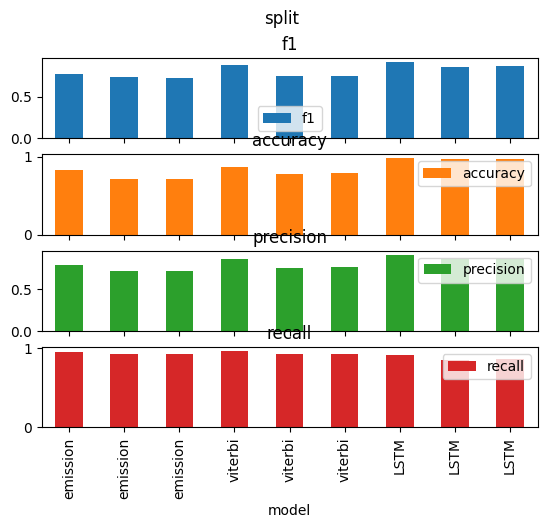

In [ ]:
df.plot(kind="bar", subplots=True,x="model")